In [1]:
import qsharp
import numpy as np
import matplotlib.pyplot as plt
from qsharp import Result
from Quantum.Isingannealing import SimulateIsingEvolution
from Quantum.Isinglongrange import Evolve, EvolveSingleTimestepDummy

# Simulation of the Ising Model

Just a playground notebook to check the qsharp code from the samples and showcase the snippet I wrote.

# Annealing

Using the existing sample code to anneal from a Hamiltonian initially aligned along x to one with only z components. How does the time step affect how well we anneal?

In [3]:
mag = []
dt_vals = np.linspace(0.1, 5, 50)
for dt in dt_vals:
    res = SimulateIsingEvolution.simulate(
        nSites=12, time=10.0, dt=dt, hz=0.5, hx=1., J=1.)
    mag.append(sum(res))

Text(0, 0.5, 'magnetisation')

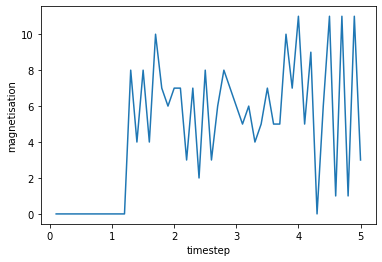

In [4]:
fig = plt.figure()
plt.plot(dt_vals, mag)
plt.xlabel('timestep')
plt.ylabel('magnetisation')

# Time evolution

Using the version I wrote which evolves a system initialy defined in the z basis under a TFIM model with all to all coupling (the strength of the couplings is defined by the scaling values where Jn = J * scaling[n + 1])

In [6]:
ave = 50
dt = 0.01
hx = 0.5
hz = 0.
J = 1
scalings = [1.]
times = np.linspace(0.5, 5, num=10)
initialState = [1, 0, 0]
ordered_result = np.zeros((len(times) + 1, len(initialState)))
ordered_result[0] = np.array(initialState)
unordered_result = np.zeros((len(times) + 1, len(initialState)))
unordered_result[0] = np.array(initialState)
for _ in range(ave):
    for i, t in enumerate(times):
        ordered_res = Evolve.simulate(
            initialState=initialState, time=t, dt=dt, hx=hx, hz=hz, J=J,
            scalings=scalings, ordered=True)
        unordered_res = Evolve.simulate(
            initialState=initialState, time=t, dt=dt, hx=hx, hz=hz, J=J,
            scalings=scalings, ordered=False)
        ordered_result[i + 1] += np.array(ordered_res) / ave
        unordered_result[i + 1] += np.array(unordered_res) / ave

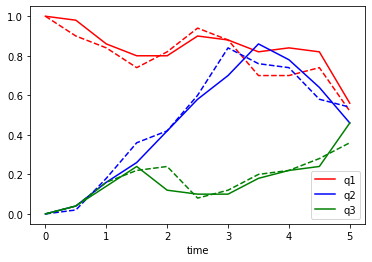

In [7]:
colors = ['r', 'b', 'g']
plottable_times = np.append(np.array([0]), times)
fig = plt.figure()
for i in range(len(initialState)):
    plt.plot(plottable_times, ordered_result[:, i], label='q{}'.format(i + 1), color=colors[i])
    plt.plot(plottable_times, unordered_result[:, i], '--', color=colors[i])
plt.xlabel('time')
plt.legend()

## Resource Estimation
Estimating resources for the evolution 

In [7]:
# for the full evolution

Evolve.estimate_resources(initialState=initialState, time=t, dt=dt, hx=hx, hz=hz, J=J,
                          scalings=scalings)

{'CNOT': 400,
 'QubitClifford': 1,
 'R': 800,
 'Measure': 3,
 'T': 0,
 'Depth': 0,
 'Width': 3,
 'BorrowedWidth': 0}

In [8]:
# for the dummy function I wrote which is identical to one time step evolution
# except that it uses freshly initialised qubits rather than acting on a register
# passed as an argument (because I couldnt work out how to do that in python)

EvolveSingleTimestepDummy.estimate_resources(dt=dt, hx=hx, hz=hz, J=J,
                              scalings=scalings, nSites=3)

{'CNOT': 4,
 'QubitClifford': 0,
 'R': 8,
 'Measure': 0,
 'T': 0,
 'Depth': 0,
 'Width': 3,
 'BorrowedWidth': 0}

# Outstanding Questions
- Is this the sort of thing you were thinking?
- I can't work out how to get depth to not only count T gates
- I havent implemented this in a way that optimises parallelism but very easily could, at the moment I couldnt get the depth part to work so I wouldn't be able to see the difference in resource estimation anyway